In [13]:
import pinocchio as pin
import math
import time
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import *
import pinocchio as pio
import eigenpy
from scipy.optimize import fmin_bfgs
import numpy as np

import casadi as ca

from pinocchio import casadi as cpin

# from pinocchio.visualize import GepettoVisualizer

import matplotlib.pyplot as plt

## **Résolution DOC : version casadi**

In [14]:
exampleRobotDataPath = '/home/n7student/Documents/Boulot/CNRS@CREATE/Codes/OC & IRL/Starting/3 - URDF et pinocchio/assets/'
urdf = exampleRobotDataPath + 'mon_robot.urdf'
robot = RobotWrapper.BuildFromURDF( urdf, [ exampleRobotDataPath, ] )
# robot.setVisualizer(GepettoVisualizer()) # AJOUT
robot.initViewer(loadModel=True)
NQ = robot.model.nq
NV = robot.model.nv

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [15]:
q = ca.SX.sym("q",NQ,1)
dq = ca.SX.sym("dq",NQ,1)

In [16]:
opti = ca.Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 100  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = ca.DM.ones((N_angles, N))
w_2 = ca.DM.ones(N)
w_3 = ca.DM.zeros(N)
w_4 = ca.DM.zeros(N)


# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
# q_sym = ca.MX.sym("q", 2)
# q_sym = ca.SX.sym("q", 2)
q1_sym = ca.SX.sym("q1")
q2_sym = ca.SX.sym("q2")
# dq_sym = ca.MX.sym("dq", 2)
# dq_sym = ca.SX.sym("dq", 2)
dq1_sym = ca.SX.sym("dq1")
dq2_sym = ca.SX.sym("dq2")


# NOTE : les implémentations de Px et gradient sont inexactes, je vais les réimplémenter

"""
# Px et gradient
Px = L_1*ca.cos(q_sym[0]) + L_2*ca.cos(q_sym[0] + q_sym[1])
grad_Px = ca.gradient(Px, q_sym)
dPx_sq_fun = ca.Function("dPx_sq", [q_sym], [ca.dot(grad_Px, grad_Px)])

# Py et gradient
Py = L_1*ca.sin(q_sym[0]) + L_2*ca.sin(q_sym[0] + q_sym[1])
grad_Py = ca.gradient(Py, q_sym)
dPy_sq_fun = ca.Function("dPy_sq", [q_sym], [ca.dot(grad_Py, grad_Py)])
"""


# Réimplémentation de Px et Py
# Px = L_1*ca.cos(q_sym[0]) + L_2*ca.cos(q_sym[0] + q_sym[1])
Px = L_1*ca.cos(q1_sym) + L_2*ca.cos(q1_sym + q2_sym)
Px_fun = ca.Function("Px", [q1_sym, q2_sym], [Px])
# Py = L_1*ca.sin(q_sym[0]) + L_2*ca.sin(q_sym[0] + q_sym[1])
Py = L_1*ca.sin(q1_sym) + L_2*ca.sin(q1_sym + q2_sym)
Py_fun = ca.Function("Py", [q1_sym, q2_sym], [Py])
# grad_Px = ca.gradient(Px, q_sym)
grad_Px = ca.gradient(Px, ca.vertcat(q1_sym, q2_sym))
# grad_Py = ca.gradient(Py, q_sym)
grad_Py = ca.gradient(Py, ca.vertcat(q1_sym, q2_sym))
# dPx_fun = ca.Function("dPx", [q_sym, dq_sym] , [grad_Px.T @ dq_sym])
dPx_fun = ca.Function("dPx", [ca.vertcat(q1_sym, q2_sym), ca.vertcat(dq1_sym, dq2_sym)] , [grad_Px.T @ ca.vertcat(dq1_sym, dq2_sym)])
# dPy_fun = ca.Function("dPy", [q_sym, dq_sym] , [grad_Py.T @ dq_sym])
dPy_fun = ca.Function("dPy", [ca.vertcat(q1_sym, q2_sym), ca.vertcat(dq1_sym, dq2_sym)] , [grad_Py.T @ ca.vertcat(dq1_sym, dq2_sym)])



# q_sym2 = ca.SX.sym("q2", 2)

# f et Jacobien
# f = ca.vertcat(L_1*ca.cos(q_sym[0]) + L_2*ca.cos(q_sym[0] + q_sym[1]),
#             L_1*ca.sin(q_sym[0]) + L_2*ca.sin(q_sym[0] + q_sym[1]))
f = ca.vertcat(L_1*ca.cos(q1_sym) + L_2*ca.cos(q1_sym + q2_sym),
            L_1*ca.sin(q1_sym) + L_2*ca.sin(q1_sym + q2_sym),
            0)
# f = ca.Function("f", [q_sym2], [ca.vertcat(L_1*ca.cos(q_sym2[0]) + L_2*ca.cos(q_sym2[0] + q_sym2[1]),
#             L_1*ca.sin(q_sym2[0]) + L_2*ca.sin(q_sym2[0] + q_sym2[1]))])
# J = ca.jacobian(f, q_sym)
J = ca.jacobian(f, ca.vertcat(q1_sym, q2_sym))
J_func = ca.Function("J_func", [q1_sym, q2_sym], [J])
JTJ = J.T @ J
# JTJ = ca.Function("JJt", [q_sym2], [J.T @ J])
eps = 1e-6
# NOTE : j'avais tenté une autre approche pour le coût suivant, mais on m'a dit de l'abandonner
# log_det_JJt_fun = Function("log_det_JJt", [q_sym2], [-log(fabs(det(JJt) - 1))])
# log_det_JJt_fun = ca.Function("log_det_JJt", [q_sym2], [-ca.log(ca.det(JTJ) + eps)])
# log_det_JJt_fun = ca.Function("log_det_JJt", [q_sym], [-ca.log(ca.det(JTJ) + eps)])
log_det_JJt_fun = ca.Function("log_det_JJt", [ca.vertcat(q1_sym, q2_sym)], [-ca.log(ca.det(JTJ) + eps)])
JJt_fun = ca.Function("JJt", [ca.vertcat(q1_sym, q2_sym)], [JTJ])

J_2 = 0
J_3 = 0
J_4 = 0
for t in range(N):
    q_t = ca.vertcat(q[0, t], q[1, t])
    dq_t = ca.vertcat(dq[0, t], dq[1, t])
    # J_2 += w_2[t] * dPx_sq_fun(q_t)
    J_2 += w_2[t] * dPx_fun(q_t, dq_t)**2
    # J_3 += w_3[t] * dPy_sq_fun(q_t)
    J_3 += w_2[t] * dPy_fun(q_t, dq_t)**2
    J_4 += w_4[t] * log_det_JJt_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3 + J_4)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, ca.pi/4])
opti.subject_to(L_1*ca.cos(q[0, -1]) + L_2*ca.cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      598
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [17]:
robot.display(np.array([q1[0], q2[0]]))

time.sleep(2)
for i in range(N):
    robot.display(np.array([q1[i],q2[i]]))
    time.sleep(0.1)

In [18]:
results_angle_casadi = np.array([q1, q2])
results_vitesses_angulaires_casadi = np.array([dq1, dq2])

## **Résolution DOC : version cpin**

In [19]:
exampleRobotDataPath = '/home/n7student/Documents/Boulot/CNRS@CREATE/Codes/OC & IRL/Starting/3 - URDF et pinocchio/assets/'
urdf = exampleRobotDataPath + 'mon_robot.urdf'
robot = RobotWrapper.BuildFromURDF( urdf, [ exampleRobotDataPath, ] )
# robot.setVisualizer(GepettoVisualizer()) # AJOUT
robot.initViewer(loadModel=True)
NQ = robot.model.nq
NV = robot.model.nv

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [20]:
cmodel = cpin.Model(robot.model)
cdata = cmodel.createData()

q = ca.SX.sym("q",NQ,1)
dq = ca.SX.sym("dq",NQ,1)
ddq = ca.SX.sym("ddq",NQ,1)     # NORMALEMENT PAS BESOIN

In [21]:
# Implémentation des fonctions nécessaires au calcul des coûts avec cpin

frame_id = cmodel.getFrameId("ee_link")

# def vtip_fun(q):
    # cpin.forwardKinematics(cmodel, cdata, q)
    # v_frame = cpin.getFrameVelocity(cmodel, cdata, frame_id, cpin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    # NOTE : vérifier que ce sont bien les deux bonnes composantes de la vitesse
    # return v_frame.linear[[0, 2]]
    # return cpin.computeFrameJacobian(cmodel, cdata, q, frame_id, cpin.ReferenceFrame.LOCAL_WORLD_ALIGNED)[:3,:]

Jv = ca.Function('Jv', [q], [cpin.computeFrameJacobian(cmodel, cdata, q, frame_id, cpin.ReferenceFrame.LOCAL_WORLD_ALIGNED)[:2,:]])

Jv_val = Jv(q)
dP = Jv_val @ ca.vertcat(dq[0],dq[1])

vx_fun = ca.Function("vx_sq_fun", [q, dq], [dP[0]])
vy_fun = ca.Function("vy_sq_fun", [q, dq], [dP[1]])

# oMtool = robot.data.oMf[IDX_EE]
# oRtool = oMtool.rotation
# Jee = oRtool[:2,:2] @ (pin.computeFrameJacobian(robot.model,robot.data,np.array([q1_test[i],q2_test[i]]),IDX_EE)[:2,:2])

jac_fun = ca.Function("jac_fun", [q], [cpin.computeFrameJacobian(cmodel, cdata, q, frame_id, cpin.ReferenceFrame.LOCAL_WORLD_ALIGNED)])

manipulability_fun = ca.Function("manipulability_fun", [q], [jac_fun(q) @ jac_fun(q).T])

cost_manipulability_fun = ca.Function("cost_manipulability_fun", [q], [-ca.log(ca.det(manipulability_fun(q)) + 1e-6)])

In [22]:
opti = ca.Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 100  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
q_fic = opti.variable(1, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = ca.DM.ones((N_angles, N))
w_2 = ca.DM.ones(N)
w_3 = ca.DM.zeros(N)
w_4 = ca.DM.zeros(N)


# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
# J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
q_sym = ca.MX.sym("q", 2)


J_1 = 0
J_2 = 0
J_3 = 0
J_4 = 0
save_cost_manipulability = []
for t in range(N):
    q_t = ca.vertcat(q[0, t], q[1, t])
    dq_t = ca.vertcat(dq[0, t], dq[1, t])
    # q_t = ca.vertcat(q[0, t], q[1, t], q_fic[0, t])
    # cpin.framesForwardKinematics(cmodel, cdata, q_t)
    J_1 += 1 * dq[0, t]**2 + 1 * dq[1, t]**2
    J_2 += 1 * vx_fun(q_t, dq_t)
    J_3 += 0 * vy_fun(q_t, dq_t)
    J_4 += 0 * cost_manipulability_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3 + J_4)

# contraintes d’intégration
opti.subject_to(q_fic[0, N-1] == 0)
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
    opti.subject_to(q_fic[0, t] == 0)
opti.subject_to(q[:, 0] == [0, ca.pi/4])
opti.subject_to(L_1*ca.cos(q[0, -1]) + L_2*ca.cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1_cpin = sol.value(q[0,:])
q2_cpin = sol.value(q[1,:])

dq1_cpin = sol.value(dq[0,:])
dq2_cpin = sol.value(dq[1,:])

print("q1 =", q1_cpin)
print("q2 =", q2_cpin)
print("dq1 =", dq1_cpin)
print("dq2 =", dq2_cpin)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      698
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      900

Total number of variables............................:      500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      301
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [23]:
robot.display(np.array([q1_cpin[0], q2_cpin[0]]))

time.sleep(2)
for i in range(N):
    robot.display(np.array([q1_cpin[i],q2_cpin[i]]))
    time.sleep(0.1)

In [24]:
results_angle_cpin = np.array([q1_cpin, q2_cpin])
results_vitesses_angulaires_cpin = np.array([dq1, dq2])

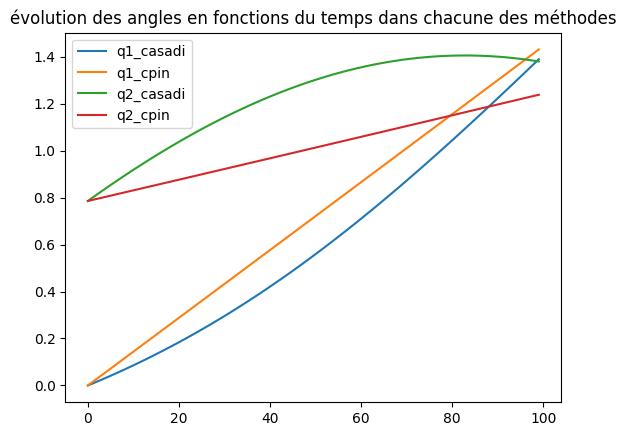

In [26]:
plt.plot(results_angle_casadi[0], label = "q1_casadi")
plt.plot(results_angle_cpin[0], label = "q1_cpin")
plt.plot(results_angle_casadi[1], label = "q2_casadi")
plt.plot(results_angle_cpin[1], label = "q2_cpin")
plt.title("évolution des angles en fonctions du temps dans chacune des méthodes")
plt.legend()
plt.show()

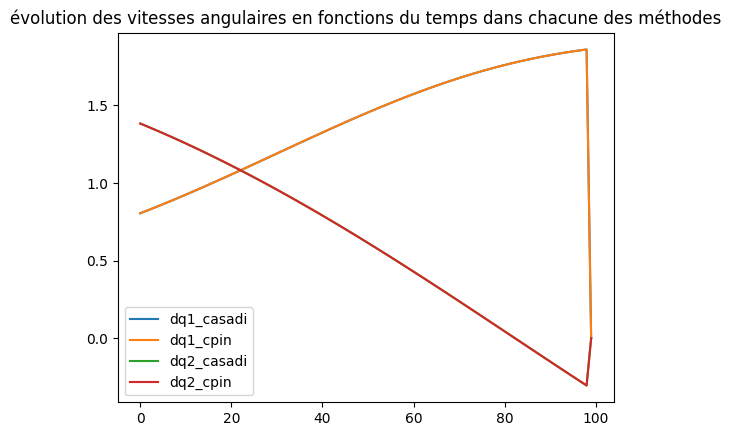

In [27]:
plt.plot(results_vitesses_angulaires_casadi[0], label = "dq1_casadi")
plt.plot(results_vitesses_angulaires_cpin[0], label = "dq1_cpin")
plt.plot(results_vitesses_angulaires_casadi[1], label = "dq2_casadi")
plt.plot(results_vitesses_angulaires_cpin[1], label = "dq2_cpin")
plt.title("évolution des vitesses angulaires en fonctions du temps dans chacune des méthodes")
plt.legend()
plt.show()

In [29]:
ecarts_angles = results_angle_casadi - results_angle_cpin
ecarts_vitesses_angulaires = results_vitesses_angulaires_casadi - results_vitesses_angulaires_cpin

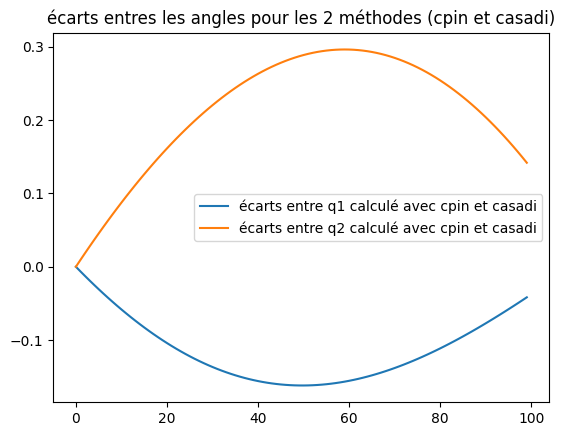

In [32]:
plt.plot(ecarts_angles[0,:], label = "écarts entre q1 calculé avec cpin et casadi")
plt.plot(ecarts_angles[1,:], label = "écarts entre q2 calculé avec cpin et casadi")
plt.legend()
plt.title("écarts entres les angles pour les 2 méthodes (cpin et casadi)")
plt.show()

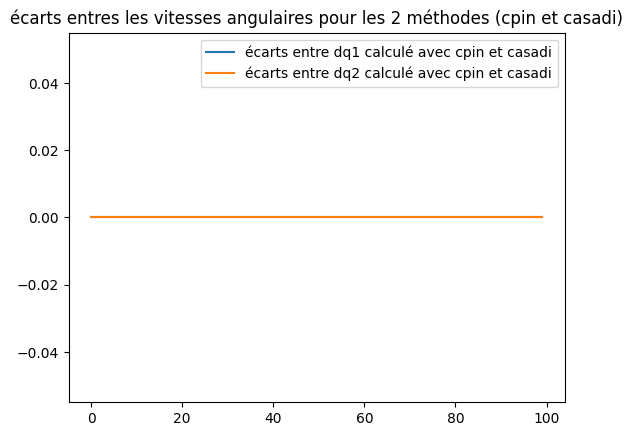

In [33]:
plt.plot(ecarts_vitesses_angulaires[0,:], label = "écarts entre dq1 calculé avec cpin et casadi")
plt.plot(ecarts_vitesses_angulaires[1,:], label = "écarts entre dq2 calculé avec cpin et casadi")
plt.legend()
plt.title("écarts entres les vitesses angulaires pour les 2 méthodes (cpin et casadi)")
plt.show()